---
title: "Nielsen's NNDL, ch.2"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

I'm not sure I have something new to add to the vast number of explanations on backpropagation found on the internet. Almost certainly I don't. However, I can only truly grasp a concept if I work it out myself, and that's what this chapter is about. I found [Andrej Karpathy's youtube video](https://www.youtube.com/watch?v=VMj-3S1tku0) on micrograd very useful. He really takes the time to explain the mechanics behind backpropagation. Another useful source was [3b1b youtube videos](https://youtu.be/Ilg3gGewQ5U?si=4q294k85uvQfBucz). It's obvious that he's restating Nielsen's arguments, but with greater pedagogical clarity and superb visualizations.  With regard to Nielsen's approach, I personally hated that he first showed the end form of the equations, and only at the very end of the chapter went about deriving them. At the outset, he says about the first equation "This is a very natural expression". Personally I found nothing natural until I fully understood the derivation. Also, the order of the equations is wrong: what we really need are equations 3 and 4, and equations 1 and 2 are the means to calculate what we need. Nielsen, if you're reading this, know that this criticism comes from a place of love, you did a great service to humanity. I'll stop ranting now, and I'll derive backpropagation myself. If you don't quite get it, it's probably because I'm writing to someone who I assumed to have read Nielsen's book (which you should).

## derivation

### cost

We start with the cost function. For one given input $x$ (one photo of a digit in our dataset), we run our neural network with the usual feed forward algorithm, and get the vector of activations $a$ at the last layer $L$. The cost then will be

$$
C_x = \frac{1}{2} \sum_j \left( y_j - a^L_j\right)^2.
$$

The one half has no special significance here, it will just make life a bit easier in the future, once we take the derivative of the cost. But let's not get distracted.

We sum over $j$, the index counting the number of neurons in the output layer, which in our case is 10. $y_j$ represents the one-hot label of the digit in $x$. For instance, for the digit $3$ we might get something like that:

$$
y =
\begin{bmatrix}
0\\0\\0\\1\\0\\0\\0\\0\\0\\0
\end{bmatrix},
\quad
a^L =
\begin{bmatrix}
0.1\\0.7\\0.0\\0.5\\0.4\\0.6\\0.1\\0.0\\0.1\\0.6
\end{bmatrix},
\quad
(y-a^L)^2 =
\begin{bmatrix}
0.01\\0.49\\0.0\\0.25\\0.16\\0.36\\0.01\\0.0\\0.01\\0.36
\end{bmatrix}.
$$

Then $C_x$ is just half of the sum of this last vector. So far so good. But what about all the other thousands of input images? We do the same for them, and get the total cost for our entire dataset:

$$
C = \frac{1}{n}\sum_x C_x
$$

### rule for updating the parameters

Our goal is to update each and every weight and bias in our neural network, so to decrease as much as we can this cost. The lower the cost, the more accurate will be our number classification.

This cost lives in a multi-dimensional space. By the gradient descent method, we take a tiny step in the parameter space in the direction opposite to the gradient of the cost. If $p$ is to represent our parameter vector, than we would write

$$
p_\text{new} = p_\text{old} - \eta \nabla C,
$$

where $\eta$ is the learning rate. 

Each element of $p$ is a weight or bias in the network. Now is the right time to be precise and refer specifically to each parameter, and first we need a good mental model for the parameters. The quantities $b$, $z$, and $a$ are easy to understand, each "belongs" to a specific neuron $j$ in a specific layer $\ell$, therefore we index them as $b^\ell_j$, $z^\ell_j$, and $a^\ell_j$. One thing we should be aware of is that the activation exists for the input layer as well, and we can denote it as $a^{-1}_j$, since I chose to index the first hidden layer as zero. Another thing is that I chose to start all the indices from zero (as is done in Python), but we could have started from one as well. The choice is arbitrary, and I it doesn't matter which one we choose, as long as we're consistent.

The weights are a bit more complicated, because they connect two neurons from neighboring layers. The easiest way to think about them is to say that a given weight belongs to a neuron $j$ in layer $\ell$, and it connects this neuron to a neuron $k$ in the previous layer $\ell-1$. Therefore we can index them as $w^\ell_{jk}$. This interpretation makes it intuitive to remember the order of the lower indices: the first one is the layer of the neuron to which the weight belongs, and the second one is the index of the neuron it connects to in the previous layer.

Lastly, the equation for computing the weighted input $z^\ell_j$ of a neuron $j$ in layer $\ell$ becomes obvious once we connect it to the figure below.

$$
z^\ell_j = \sum_k w^\ell_{jk} a^{\ell-1}_k + b^\ell_j.
$$

In [8]:
#| code-summary: "import libraries"
import os
import io
import gzip
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as patches

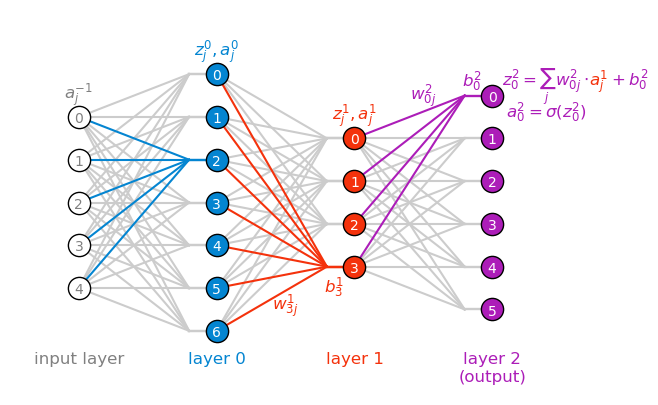

In [9]:
#| code-summary: "plot NN"
fig, ax = plt.subplots(figsize=(8, 5))
layer_left = 5
layer_center = 7
layer_right = 4
layer_right2 = 6

layers = [layer_left, layer_center, layer_right, layer_right2]

weights = []
for l, layer in enumerate(layers[:-1]):
    weights.append(np.ones((layers[l+1], layer)))

for l,w in enumerate(weights):
    x_left = l
    x_right = l+1-0.2
    x_b = l+1
    for index, value in np.ndenumerate(w):
        y_right = index[0] - layers[l+1]/2
        y_left = index[1] - layers[l]/2
        zorder = 100
        if (l==0 and index[0]==4):
            color = "xkcd:cerulean"
        elif (l==1 and index[0]==0):
            color = "xkcd:vermillion"
        elif (l==2 and index[0]==layers[l+1]-1):
            color = "xkcd:barney"
            
        else: color = [0.8]*3; zorder = 0
        ax.plot([x_left, x_right], [y_left, y_right], color=color, zorder=zorder)
        ax.plot([x_b, x_right], [y_right, y_right], color=color, zorder=zorder)

ax.text(3-0.15, np.max(layers)/2 - 1 +0.1, fr"$b_{{0}}^{2}$", ha="center", va="top", fontsize=12, color=color, zorder=1000)
ax.text(3-0.5, np.max(layers)/2 - 1 - 0.2, fr"$w_{{0j}}^{2}$", ha="center", va="top", fontsize=12, color=color, zorder=1000)
ax.text(3+0.6, np.max(layers)/2 - 1.3, fr"$z_{{0}}^{2} = \sum_j w_{{0j}}^{l}\cdot \quad + b_{{0}}^{l}$", ha="center", va="center", fontsize=12, color=color, zorder=1000)

ms = 16
neuron_colors = ['white', 'xkcd:cerulean', 'xkcd:vermillion', 'xkcd:barney']
text_colors = ['gray', 'white', 'white', 'white']
for l, layer in enumerate(layers):
    for i in range(layer):
        ax.plot([l], [i - layer/2], ls='None', marker='o', mfc=neuron_colors[l], mec="black", markersize=ms,
                color=neuron_colors[l], lw=2, alpha=1.0, zorder=1000)
        ax.text(l, i - layer/2-0.05, f"{layer-i-1}", ha="center", va="center", fontsize=10, color=text_colors[l], zorder=1000)   

ax.text(0, -np.max(layers)/2-0.5, f"input layer", ha="center", va="top", fontsize=12, color="gray", zorder=1000)
ax.text(1, -np.max(layers)/2-0.5, f"layer 0", ha="center", va="top", fontsize=12, color="xkcd:cerulean", zorder=1000)
ax.text(2, -np.max(layers)/2-0.5, f"layer 1", ha="center", va="top", fontsize=12, color="xkcd:vermillion", zorder=1000)
ax.text(3, -np.max(layers)/2-0.5, f"layer 2\n(output)", ha="center", va="top", fontsize=12, color="xkcd:barney", zorder=1000)

ax.text(2-0.5, -2.6, fr"$w_{{3j}}^1$", ha="center", va="top", fontsize=12, color="xkcd:vermillion", zorder=1000)
ax.text(2-0.15, -2.2, fr"$b_{{3}}^1$", ha="center", va="top", fontsize=12, color="xkcd:vermillion", zorder=1000)
ax.text(2, (layers[2])/2-0.5, fr"$z_{{j}}^{1},a_{{j}}^{1}$", ha="center", va="center", fontsize=12, color="xkcd:vermillion", zorder=1000)
ax.text(3+0.6+0.17, np.max(layers)/2 - 1.2, fr"$a_{{j}}^{1}$", ha="center", va="center", fontsize=12, color="xkcd:vermillion", zorder=1000)
ax.text(3.1, np.max(layers)/2 - 1.9, fr"$a_{{0}}^{2}=\sigma(z_{{0}}^{2})$", ha="left", va="center", fontsize=12, color="xkcd:barney", zorder=1000)
ax.text(1, (layers[1])/2-0.5, fr"$z_{{j}}^{0},a_{{j}}^{0}$", ha="center", va="center", fontsize=12, color="xkcd:cerulean", zorder=1000)
ax.text(0, (layers[0])/2-0.5, fr"$a_{{j}}^{{-1}}$", ha="center", va="center", fontsize=12, color="gray", zorder=1000)
ax.set(xlim=(-0.5, 4), ylim=(-5, 4), xticks=[], yticks=[])
# ax.set_aspect('equal')
ax.axis('off');

In the figure above, I color coded  $z$, $a$, $w$ and $b$ by color, each color corresponding to a specific layer.

Translating the general parameter in the equation above to weights and biases gives the following update rules:

\begin{align*}
w_{jk}^\ell &\leftarrow w_{jk}^{\ell} - \eta \frac{\partial C}{\partial w_{jk}^{\ell}} \\ \\
b_j^\ell &\leftarrow b_j^{\ell} - \eta \frac{\partial C}{\partial b_j^{\ell}}.
\end{align*}


### the structure of the argument

The backpropagation algorithm is at its essence an induction.

1. We can find out the partial derivatives for the very last layer, the output layer. This is the Base Case.
1. We can show that given the partial derivatives in any given layer $\ell$, we can figure out what the partial derivatives are in the layer that precedes it, $\ell-1$. This is the Inductive Step.
1. That's it. Starting from the last layer, we can work our way out to the first layer. That explains the name of the algorithm, we're backpropagating the information, from last to first.

## the "error"

For a given weight or bias, let's use the chain rule to begin unfolding the partial derivatives we need to find out. It's best to rewrite an equation we saw before, to make the derivatives easier to understand: $z^\ell_j = \sum_k w^\ell_{jk} a^{\ell-1}_k + b^\ell_j$.

\begin{align*}
\frac{\partial C}{\partial w^\ell_{jk}} &= \left( \frac{\partial C}{\partial z^\ell_j} \right) \frac{\partial z^\ell_j}{\partial w^\ell_{jk}} = \left( \frac{\partial C}{\partial z^\ell_j} \right) a^{\ell-1}_k  \\ \\
\frac{\partial C}{\partial b^\ell_j} &= \left(\frac{\partial C}{\partial z^\ell_j}\right) \frac{\partial z^\ell_j}{\partial b^\ell_j} = \left( \frac{\partial C}{\partial z^\ell_j} \right).
\end{align*}

This is great, now both terms look almost the same! We found that we need to calculate the quantity in the parentheses, which we will call the **error**:

$$
\delta^\ell_j =\frac{\partial C}{\partial z^\ell_j}
$$

The equation above asks: how sensitive is the total cost $C$ to tiny variations in a specific weighted input $z$ at the $j$th neuron in layer $\ell$.

Let's compute this error for the last layer $L$, and lay out the Base Case of our induction.

## base case: the output layer

The last layer has index $L$, and the error for the $j$th neuron in this layer is
$$
\delta^L_j = \frac{\partial C}{\partial z^L_j}.
$$

Let's use the chain rule to unfold this derivative:

$$
\delta^L_j = \frac{\partial C}{\partial a^L_j} \frac{\partial a^L_j}{\partial z^L_j}.
$$

Remember that the activation $a$ is simply

$$
a = \sigma(z),
$$

so we have that $\partial a/\partial z=\sigma'(z)$. Rewriting the error gives

$$
\delta^L_j = \frac{\partial C}{\partial a^L_j} \cdot \sigma'(z^L_j).
$$

We're in luck, because each of the two terms in the right hand side of the equation above is easy to calculate. The first term is

\begin{align*}
\frac{\partial C}{\partial a^L_j} &= \frac{\partial}{\partial a^L_j} \left[ \frac{1}{n}\sum_x \frac{1}{2} \sum_j \left( y_j - a^L_j\right)^2 \right] \\
&=
\frac{1}{n}\sum_x \sum_j \left( y_j - a^L_j\right).
\end{align*}

Let's translate that into words: the first term is simply the difference $\left( y_j - a^L_j\right)$, summed over all neurons $j$ in the output layer, and averaged over all input images $x$. That's super easy to compute! Let's see the second term:

$$
\sigma'(z^L_j).
$$

The derivative of $\sigma$ depends on the specific function we choose. Let's calculate what the answer would be for two commonly used activation functions, the sigmoid and relu. For the sigmoid:

\begin{align*}
\sigma(z) &= \frac{1}{1+\exp(-z)} \\
\sigma'(z) &= \sigma(z)\left(1-\sigma(z)\right).
\end{align*}

For the relu:

\begin{align*}
\sigma(z) &= \max(0,z) \\
\sigma'(z) &= \begin{cases}
0 & z < 0 \\
1 & z > 0
\end{cases}
\end{align*}

In either case, the derivative is easy to compute, and we have the Base Case of our induction.

## the inductive step: the hidden layers

The arguments here are also based on a bunch of partial derivatives and the chain rule. We start from the error in a generic hidden layer $\ell$:

$$
\delta^\ell_j = \frac{\partial C}{\partial z^\ell_j}.
$$

This error is influenced by the errors in the next layer $\ell+1$, so we now use the chain rule to express this relationship:

$$
\delta^\ell_j = \sum_k \frac{\partial C}{\partial z^{\ell+1}_k} \frac{\partial z^{\ell+1}_k}{\partial z^\ell_j} = \underbrace{\sum_k \delta^{\ell+1}_k \frac{\partial z^{\ell+1}_k}{\partial z^\ell_j}}_{\text{summation over layer $\ell+1$}}.
$$

Let's interpret this equation, using the image below to help us. We are already used to the idea that the activation of a neuron in layer $\ell$ propagates to the next layer $\ell+1$, from left to right. This is what the blue lines in the image below represent.

The conceptual jump now is to use these same lines to understand how the error in layer $\ell+1$ **propagates back** to layer $\ell$, from right to left. The equation above says that the error in layer $\ell$ is the sum of the errors in layer $\ell+1$, weighted by something that should be related to the strength of the connection between the neurons in layer $\ell$ and layer $\ell+1$.

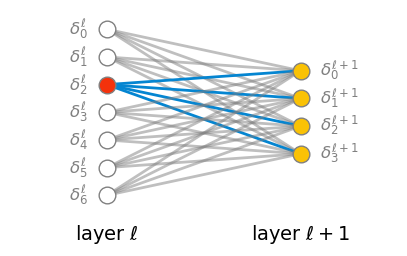

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

layer_left = 7
layer_right = 4
ms = 12
for i in range(layer_left):
    for j in range(layer_right):
        if i == 2:
            color = "xkcd:cerulean"
            alpha = 1.0
        else:
            alpha = 0.5
            color = "gray"
        ax.plot([0, 1], [(layer_left - i)/layer_left, (layer_right - j + 1.5)/layer_left], 
                color=color, lw=2, alpha=alpha)
        

for i in range(layer_left):
    if i == 2:
        color = "xkcd:vermillion"
        alpha = 1.0
    else:
        color = "white"
        alpha = 1.0
    ax.plot([0], [(layer_left - i)/layer_left], ls='None', marker='o', mfc=color, 
            mec="gray", markersize=ms, alpha=alpha)
    ax.text(-0.1, (layer_left - i)/layer_left, fr"$\delta_{i}^\ell$", 
                va='center', ha='right', fontsize=12, color="gray")
    
for i in range(layer_right):
    color = "xkcd:goldenrod"
    ax.plot([1], [(layer_right - i + 1.5)/layer_left], ls='None', marker='o', mfc=color, 
            mec="gray", markersize=ms)
    ax.text(1.1, (layer_right - i + 1.5)/layer_left, fr"$\delta_{i}^{{\ell+1}}$", 
                va='center', ha='left', fontsize=12, color="gray")

# ax.text(0.5, 0.9, r"$w_{ij}$", fontsize=12, color="gray")
ax.text(0, 0, r"layer $\ell$", va="top", ha="center", fontsize=14)
ax.text(1, 0, r"layer $\ell+1$", va="top", ha="center", fontsize=14)

ax.set(xlim=(-0.5, 1.5), ylim=(0, 1.1), xticks=[], yticks=[])
ax.set_aspect('equal')
ax.axis('off');

We need now to evaluate the term

$$
\frac{\partial z^{\ell+1}_k}{\partial z^\ell_j}.
$$

Remember that the weighted input $z$, at the $k$-th neuron in layer $\ell+1$, is defined as

$$
z^{\ell+1}_k = \sum_j w_{kj}^{\ell+1} a^\ell_j + b_k^{\ell+1}.
$$

Remember also that the activation $a$ is a function of the weighted input $z$, $a = \sigma(z)$. Putting all this together gives

\begin{align*}
\frac{\partial z^{\ell+1}_k}{\partial z^\ell_j} &= \frac{\partial z^{\ell+1}_k}{\partial a^\ell_j} \cdot \frac{\partial a^\ell_j}{\partial z^\ell_j} \\
&= w_{kj}^{\ell+1} \sigma'(z^\ell_j).
\end{align*}

Finally, we can rewrite the error in layer $\ell$ as

$$
\delta^\ell_j = \sum_k \delta^{\ell+1}_k w_{kj}^{\ell+1} \sigma'(z^\ell_j).
$$

Once more, all the terms in the right hand side of the equation above are easy to compute, and we have the Inductive Step of our argument.

## summary

We've learned the following. For each weight and bias $j$ in any layer $\ell$, we can compute the error $\delta^\ell_j$ and update the parameters according to:

\begin{align*}
w_{jk}^\ell &\leftarrow w_{jk}^\ell - \eta a^{\ell-1}_k \delta_j^\ell \\ \\
b_j^\ell &\leftarrow b_j^\ell - \eta \delta_j^\ell.
\end{align*}

The backpropagation algorithm tells us to start from the last layer, compute the error there, and then work our way back to the first layer, computing the error in each layer and updating the parameters accordingly. The errors in the last layer are:

$$
\delta^L_j = \left[ \frac{1}{n}\sum_x \sum_k(y_k - a_k^L) \right] \cdot \sigma'(z^L_j),
$$

and the errors in the hidden layers are:

$$
\delta^\ell_j = \sum_k \delta^{\ell+1}_k w_{kj}^{\ell+1} \sigma'(z^\ell_j).
$$

## batches

Instead of computing the cost and the errors for the entire dataset, we can do it for a small random sample of the data, called a batch. We just need to reinterpret the summation over $x$ in the equations above as a summation over the batch. This is what stochastic gradient descent does. It allows us to update the parameters more frequently, and it also adds some noise to the process, which makes our descent in the cost landscape less smooth, but can also help to escape local minima.

We start by shuffling our dataset, and then splitting it into batches. Then, for each batch, we perform:

1. the feedforward algorithm to compute the activations and weighted inputs for each layer, and finally the cost for the batch;
1. the backpropagation algorithm to compute the errors for each layer.
1. the update of the parameters according to the equations above.

Once we've done this for all batches, we have gone through the whole dataset, and we call this one **epoch** of training. We can repeat this process for as many epochs as we want, until the cost is sufficiently low. We usually test the performance of our network on a separate test set, and track it as a function of the number of epochs.

## vectorizing Nielsen's backpropagation code

Nielsen mentions in the book that the code, as it is written, is not optimized. He proposes the following problem to solve:

> **Fully matrix-based approach to backpropagation over a mini-batch**  
  Our implementation of stochastic gradient descent loops over training examples in a mini-batch. It's possible to modify the backpropagation algorithm so that it computes the gradients for all training examples in a mini-batch simultaneously. The idea is that instead of beginning with a single input vector, x, we can begin with a matrix X=[x1x2…xm] whose columns are the vectors in the mini-batch. We forward-propagate by multiplying by the weight matrices, adding a suitable matrix for the bias terms, and applying the sigmoid function everywhere. We backpropagate along similar lines. Explicitly write out pseudocode for this approach to the backpropagation algorithm. Modify network.py so that it uses this fully matrix-based approach. The advantage of this approach is that it takes full advantage of modern libraries for linear algebra. As a result it can be quite a bit faster than looping over the mini-batch. (On my laptop, for example, the speedup is about a factor of two when run on MNIST classification problems like those we considered in the last chapter.) In practice, all serious libraries for backpropagation use this fully matrix-based approach or some variant.

I'll write below the actual code, not the pseudocode. I'll then compare the performance of the vectorized code with the original code, and see if I can get a speedup of about a factor of two, as Nielsen claims.

Note: I've made a few updates to the original code in the book. In general, I wrote it to be more "modern" (I'm writing this in 2026). Also, I made sure I didn't copy and paste anything, I'm typing it myself so I take ownership of this code. Here are the major modifications in this chapter:

1. I've added ReLU as the default activation function, but you can choose sigmoid if you want.
1. I added a progress bar to the training loop using `tqdm` to visualize the training progress.
1. You can quit training early by pressing `Ctrl+C`, the model will keep the weights without raising an error.
1. I've vectorized the backpropagation algorithm to handle batches efficiently, which should speed up training significantly.

In [48]:
import numpy as np
Nminus1 = 784
N0 = 50
w = np.ones(shape=(N0, Nminus1))
a = np.ones(shape=(Nminus1, 1))
b = np.ones(shape=(N0, 1))
(np.dot(w, a) + b).shape

batch_size = 11
n = len(training_data)
batches = [
                training_data[k:k+batch_size]
                for k in range(0, n, batch_size)
            ]
batch0 = batches[0]

In [50]:
np.broadcast_to(b, (N0, batch_size)).shape

(50, 11)

In [52]:
input = np.hstack([data[0].reshape(-1, 1) for data in batch0])
target = np.hstack([data[1].reshape(-1, 1) for data in batch0])
(np.dot(w, input) + np.broadcast_to(b, (N0, batch_size))).shape

(50, 11)

In [57]:
np.sum(target, axis=1, keepdims=True).shape

(10, 1)

In [26]:
(batches[1][2])[0].shape

(784, 1)

In [ ]:
#| code-fold: false
def sigmoid(z):
    """The sigmoid function, JIT-compiled for speed."""
    return 1.0 / (1.0 + np.exp(-z))

def relu(z):
    """The ReLU function, JIT-compiled for speed."""
    return np.maximum(0, z)

def sigmoid_prime(z):
    """Derivative of the sigmoid function, JIT-compiled for speed."""
    s = 1.0 / (1.0 + np.exp(-z))
    return s * (1 - s)

def relu_prime(z):
    """Derivative of the ReLU function, JIT-compiled for speed."""
    return np.where(z > 0, 1.0, 0.0)

class NN:
    def __init__(self, layer_sizes, rand_seed=0, activation="relu", cost="mse"):
        """Initialize the neural network with the given layer sizes.
        For example, if layer_sizes = [50, 15, 20, 10], then we have a
        network with 50 input neurons, 15 neurons in hidden layer 0,
        20 neurons in hidden layer 1, and 10 output neurons (layer 3).
        """
        self.number_of_layers = len(layer_sizes) - 1
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.rng = np.random.default_rng(seed=rand_seed)
        if activation == 'relu':
            self.activation_func = relu
            self.activation_prime = relu_prime
        elif activation == 'sigmoid':
            self.activation_func = sigmoid
            self.activation_prime = sigmoid_prime
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'sigmoid'.")
        if cost == 'mse':
            self.cost_func = lambda output, target: np.mean((output - target) ** 2) / 2
            self.cost_derivative = lambda output, target: (output - target)
        else:
            raise ValueError("Unsupported cost function. Use 'mse'.")
        # randomly initialize weights and biases
        # input layer has no weights nor biases, so we skip it.
        rng = np.random.default_rng(seed=rand_seed)
        # each neuron get 1 bias, so bias vector has the size of the layer
        # we skip the first (input) layer, it doesn't have biases
        # I made the biases to be matrices of shape (N_b, 1) instead of vectors of shape (N_b,)
        # to make the broadcasting work more smoothly in the feedforward and backpropagation functions.
        self.biases = [rng.normal(loc=0, scale=1, size=(N_b, 1))
                       for N_b in layer_sizes[1:]]
        # each neuron in layer Right is connected to all neurons in layer Left,
        # so weight matrix has the shape (size_right, size_left)
        # again, we skip the first (input) layer, it doesn't have weights
        # scale_for_weights = np.sqrt(2.0/size_left)
        scale_for_weights = 1
        self.weights = [rng.normal(loc=0, scale=scale_for_weights, size=(size_right, size_left))
                        for size_left, size_right in
                          zip(layer_sizes[:-1],layer_sizes[1:])
                        ]
    
    def feedforward(self, a):
        """given input `a` from the first layer,
           we sequencially compute the activations of each layer
           `feedforward` returns the activations of last (output) layer
        """
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            a = self.activation_func(z)
        return a
    
    def stochastic_gradient_descent(self, training_data, epochs, batch_size, eta, test_data=None):
        n = len(training_data)
        try:
            for epoch_j in range(epochs):
                # shuffle training data at the beginning of each epoch
                self.rng.shuffle(training_data)
                # split training data into batches
                batches = [
                    training_data[k:k+batch_size]
                    for k in range(0, n, batch_size)
                ]

                # ASCII Progress bar with Epoch X/Y description
                pbar = tqdm(batches, desc=f"Epoch {epoch_j+1}/{epochs}", leave=True)
                    
                # now loop over batches, update weights
                for batch in pbar:
                    self.update_params_batch(batch, eta)
                # for batch in batches:
                #     self.update_params_batch(batch, eta)
                if test_data:
                    print(f"Accuracy = {self.evaluate(test_data)/len(test_data):.2%} ({self.evaluate(test_data)}/{len(test_data)})")
                else:
                    pass
                    # print(f"Epoch {epoch_j:02d} complete")
        except KeyboardInterrupt:
            if 'pbar' in locals():
                pbar.close()
            print("\n\nTraining interrupted by user. Weights preserved.")
    
    def update_params_batch(self, batch, eta):
        # 1. make input matrix, use column-major order, so each column is a training example, and each row is a feature.
        # input = np.array([data[0] for data in batch]).T
        # 2. make label matrix, use column-major order, so each column is a training example, and each row is a label.
        # target = np.array([data[1] for data in batch]).T
        input = np.hstack([data[0].reshape(-1, 1) for data in batch])
        target = np.hstack([data[1].reshape(-1, 1) for data in batch])
        # 3. compute the gradients for the whole batch using back propagation
        nabla_b, nabla_w = self.back_propagation(input, target)
        # update biases and weights
        m = len(batch)
        self.biases = [
            b - (eta/m) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]
        self.weights = [
            w - (eta/m) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
    
    def back_propagation(self, input, target):
        ###############################
        # 1. forward pass
        # 1a. create variables to store the activations and z vectors for each layer
        # activation starts with the input layer activations, which is just the input data
        activation = input
        activation_list = [input]  # initialize with input layer activations
        # weighted input start at the first hidden layer, so we initialize an empty list
        z_list = []
        # 1b. loop over layers in forward direction, starting from the first hidden layer,
        # compute and store the activations and z vectors layer by layer
        # for the whole batch at once.
        for b, w in zip(self.biases, self.weights):
            layer_size = b.shape[0]
            # b is a vector of shape (layer_size, 1), we need to broadcast it (stack it horizontally)
            # to match the shape of the dot product w @ activation, which is (layer_size, batch_size)
            B = np.broadcast_to(b, (layer_size, input.shape[1]))
            z = np.dot(w, activation) + B
            activation = self.activation_func(z)
            z_list.append(z)
            activation_list.append(activation)
        ###############################
        # now we have all the information we need to compute the gradients in the backward pass.
        ###############################
        # 2. backward pass
        # 2a. create empty lists to store the gradients for biases and weights, layer by layer
        nabla_b = [np.zeros_like(b) for b in self.biases]
        nabla_w = [np.zeros_like(w) for w in self.weights]
        # 2b. first compute the error "delta" for the output layer
        # this is what we called the "base case"
        delta = self.cost_derivative(activation_list[-1], target) * self.activation_prime(z_list[-1])
        # 2c. compute and store the gradients for the output layer
        # we use activation_list[-2] because the rule for updating the weights requires the activations from the previous layer,
        # which is the second to last layer in the list. The transpose is needed to match the dimensions of the matrices
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, activation_list[-2].T)
        # 2c. loop over layers in reverse order,
        # compute the gradients for each layer. This is the "inductive step".
        # the loop starts at the second to last layer, and goes backwards to the first hidden layer.
        for l in range(2, self.number_of_layers+1):
            z = z_list[-l]
            # the order of the dot product and the transpose of the weights are needed
            # to match the dimensions of the matrices
            delta = np.dot(self.weights[-l+1].T, delta) * self.activation_prime(z)
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, activation_list[-l-1].T)
        return nabla_b, nabla_w
    
    def evaluate(self, test_data):
        """Return the number of correct classifications."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

I heavily commented the code above, but I still don't expect it to be understandable. The first time I tried to convert Nielsen's code to a vectorized version, I used Gemini or ChatGPT, and it immediately spit out a fully functioning code. The structure of this new code was very similar to the original, but I couldn't say that I understood the details of the matrix multiplications. I then decided to code it myself, and make sure I know exactly every step of the way. I knew I was doing something right when I ran into bugs for a full day. The code either didn't run because of a shape mismatch, or it ran but the performance didn't change at all as epochs went by. What was missing for me was pencil and paper work. I had to write down the shapes of all the matrices and vectors involved in the feedforward and backpropagation algorithms, and make sure they all matched up. Once I did that, I knew exactly what to fix, and voilà, the code worked. I know I will forget in 10 minutes why the code works, and from now on I'll just believe that it does what it is supposed to do, but I'll have the confidence that I understood it once, and that's a great feeling to have. See below one of my pencil and paper notes, as a proof of my hard work.

![](index_verification.png){width=400}

In [12]:
#| code-summary: "define function to load MNIST from web"
def load_mnist_from_web():
    urls = {
        "train_img": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
        "train_lbl": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
        "test_img": "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
        "test_lbl": "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz"
    }

    data_results = {}

    for key, url in urls.items():
        print(f"Fetching {key}...")
        response = requests.get(url)
        response.raise_for_status()
        
        # Wrap the content in BytesIO and decompress in memory
        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
            if "img" in key:
                # Images: offset 16
                data_results[key] = np.frombuffer(f.read(), np.uint8, offset=16)
            else:
                # Labels: offset 8
                data_results[key] = np.frombuffer(f.read(), np.uint8, offset=8)

    # Re-format to Nielsen's expected structure
    def vectorized_result(j):
        e = np.zeros((10, 1))
        e[j] = 1.0
        return e

    training_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in data_results["train_img"].reshape(-1, 784)]
    training_results = [vectorized_result(y) for y in data_results["train_lbl"]]
    training_data = list(zip(training_inputs, training_results))

    test_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in data_results["test_img"].reshape(-1, 784)]
    test_data = list(zip(test_inputs, data_results["test_lbl"]))

    return training_data, test_data

In [13]:
#| code-summary: "load MNIST data into memory"
training_data, test_data = load_mnist_from_web()
print(f"Loaded {len(training_data)} training samples directly into memory.")

Fetching train_img...
Fetching train_lbl...
Fetching test_img...
Fetching test_lbl...
Loaded 60000 training samples directly into memory.


In [100]:
net = NN(layer_sizes=[784, 30, 10], activation="sigmoid", rand_seed=3)
net.stochastic_gradient_descent(training_data=training_data,
        epochs=10,
        batch_size=100,
        eta=10,
        test_data=test_data)

Epoch 1/10: 100%|██████████| 600/600 [00:01<00:00, 497.24it/s]


Accuracy = 78.36% (7836/10000)


Epoch 2/10: 100%|██████████| 600/600 [00:01<00:00, 573.09it/s]


Accuracy = 81.58% (8158/10000)


Epoch 3/10: 100%|██████████| 600/600 [00:00<00:00, 622.85it/s]


Accuracy = 85.97% (8597/10000)


Epoch 4/10: 100%|██████████| 600/600 [00:01<00:00, 453.76it/s]


Accuracy = 92.57% (9257/10000)


Epoch 5/10: 100%|██████████| 600/600 [00:01<00:00, 386.50it/s]


Accuracy = 92.62% (9262/10000)


Epoch 6/10: 100%|██████████| 600/600 [00:01<00:00, 536.86it/s]


Accuracy = 93.06% (9306/10000)


Epoch 7/10: 100%|██████████| 600/600 [00:00<00:00, 616.38it/s]


Accuracy = 93.38% (9338/10000)


Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 536.40it/s]


Accuracy = 93.53% (9353/10000)


Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 356.56it/s]


Accuracy = 93.83% (9383/10000)


Epoch 10/10: 100%|██████████| 600/600 [00:01<00:00, 588.62it/s]


Accuracy = 93.87% (9387/10000)
